In [1]:
import torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/johnwu3/PyHealth/')

from pyhealth.models import Transformer
from pyhealth.interpret.tasks.methods.chefer import CheferRelevance


In [2]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        dev=True,
)

print (mimic3_ds.stat())
# data format
mimic3_ds.info()
from pyhealth.tasks import length_of_stay_prediction_mimic3_fn

mimic3_ds = mimic3_ds.set_task(task_fn=length_of_stay_prediction_mimic3_fn)
# stats info
print (mimic3_ds.stat())


{
    "patient_id": "p001",
    "visit_id": "v001",
    "diagnoses": [...],
    "labs": [...],
    "procedures": [...],
    "label": 1,
}

from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=1, shuffle=False)
mimic3_ds.samples[0].keys()

from pyhealth.models import Transformer
model = Transformer(
        dataset=mimic3_ds,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["conditions", "procedures", "drugs"],
        label_key="label",
        mode="multiclass",
    )

print("Testing MIMIC3 STUFF")
sample = test_loader.dataset[0]

print(sample)

print("----")
print(model)
# exit(0)
from pyhealth.trainer import Trainer

trainer = Trainer(
    model=model,
    metrics=["accuracy", "f1_weighted"], # the metrics that we want to log
    )

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=30,
    monitor="accuracy",
    monitor_criterion="max",optimizer_class=torch.optim.AdamW
)
data_iterator = iter(test_loader)
data = next(data_iterator)
print(data)
model(**data)

relevance = CheferRelevance(model)
# returns a list ofr now
# interpretability code here!
data['class_index'] = data['label']
rel_scores = relevance.get_relevance_matrix(**data)

# weigh and plot these scores and their corresponding feature list
print(rel_scores)


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



Generating samples for length_of_stay_prediction_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 82354.29it/s]
/home/johnwu3/PyHealth/pyhealth/trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: length_of_stay_prediction_mimic3_fn
	- Number of samples: 896
	- Number of patients: 886
	- Number of visits: 896
	- Number of visits per patient: 1.0113
	- conditions:
		- Number of conditions per sample: 9.7377
		- Number of unique conditions: 1699
		- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]
	- procedures:
		- Number of procedures per sample: 3.5647
		- Number of unique procedures: 558
		- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]
	- drugs:
		- Number of drugs per sample: 32.5804
		- Number of unique drugs: 1911
		- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362), ('00338004903', 317), ('00338001702', 305), (

Epoch 0 / 30: 100%|██████████| 12/12 [00:00<00:00, 16.37it/s]

--- Train epoch-0, step-12 ---
loss: 4.5111



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 190.75it/s]

--- Eval epoch-0, step-12 ---
accuracy: 0.3000
f1_weighted: 0.2096
loss: 3.1545
New best accuracy score (0.3000) at epoch-0, step-12




Epoch 1 / 30: 100%|██████████| 12/12 [00:00<00:00, 94.43it/s]

--- Train epoch-1, step-24 ---
loss: 3.6992



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 196.19it/s]

--- Eval epoch-1, step-24 ---
accuracy: 0.2778
f1_weighted: 0.2208
loss: 2.9139




Epoch 2 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.88it/s]

--- Train epoch-2, step-36 ---
loss: 2.9201



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.92it/s]

--- Eval epoch-2, step-36 ---
accuracy: 0.2444
f1_weighted: 0.2032
loss: 2.8704




Epoch 3 / 30: 100%|██████████| 12/12 [00:00<00:00, 91.86it/s]

--- Train epoch-3, step-48 ---
loss: 2.5562



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 199.35it/s]

--- Eval epoch-3, step-48 ---
accuracy: 0.2778
f1_weighted: 0.2264
loss: 2.9516




Epoch 4 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.93it/s]

--- Train epoch-4, step-60 ---
loss: 2.3690



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.23it/s]

--- Eval epoch-4, step-60 ---
accuracy: 0.2444
f1_weighted: 0.1836
loss: 2.9244




Epoch 5 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.85it/s]

--- Train epoch-5, step-72 ---
loss: 1.9395



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 198.16it/s]

--- Eval epoch-5, step-72 ---
accuracy: 0.2556
f1_weighted: 0.2052
loss: 2.8662




Epoch 6 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.62it/s]

--- Train epoch-6, step-84 ---
loss: 1.7535



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.46it/s]

--- Eval epoch-6, step-84 ---
accuracy: 0.2444
f1_weighted: 0.1897
loss: 2.8942




Epoch 7 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.93it/s]

--- Train epoch-7, step-96 ---
loss: 1.5257



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.67it/s]

--- Eval epoch-7, step-96 ---
accuracy: 0.2556
f1_weighted: 0.1898
loss: 3.0455




Epoch 8 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.10it/s]

--- Train epoch-8, step-108 ---
loss: 1.3150



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.20it/s]

--- Eval epoch-8, step-108 ---
accuracy: 0.2444
f1_weighted: 0.1966
loss: 3.0844




Epoch 9 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.68it/s]

--- Train epoch-9, step-120 ---
loss: 1.3034



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 203.29it/s]

--- Eval epoch-9, step-120 ---
accuracy: 0.2222
f1_weighted: 0.1905
loss: 3.0797




Epoch 10 / 30: 100%|██████████| 12/12 [00:00<00:00, 97.17it/s]

--- Train epoch-10, step-132 ---
loss: 1.1562



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 198.67it/s]

--- Eval epoch-10, step-132 ---
accuracy: 0.2444
f1_weighted: 0.1997
loss: 3.1196




Epoch 11 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.37it/s]

--- Train epoch-11, step-144 ---
loss: 1.0653



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.17it/s]

--- Eval epoch-11, step-144 ---
accuracy: 0.2667
f1_weighted: 0.2202
loss: 3.2089




Epoch 12 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.88it/s]

--- Train epoch-12, step-156 ---
loss: 0.9936



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.62it/s]

--- Eval epoch-12, step-156 ---
accuracy: 0.2556
f1_weighted: 0.2144
loss: 3.2332




Epoch 13 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.58it/s]

--- Train epoch-13, step-168 ---
loss: 0.9488



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.62it/s]

--- Eval epoch-13, step-168 ---
accuracy: 0.2667
f1_weighted: 0.2129
loss: 3.3312




Epoch 14 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.35it/s]

--- Train epoch-14, step-180 ---
loss: 0.8651



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.64it/s]

--- Eval epoch-14, step-180 ---
accuracy: 0.2556
f1_weighted: 0.2095
loss: 3.4241




Epoch 15 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.46it/s]

--- Train epoch-15, step-192 ---
loss: 0.7304



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.33it/s]

--- Eval epoch-15, step-192 ---
accuracy: 0.2333
f1_weighted: 0.2026
loss: 3.4344




Epoch 16 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.49it/s]

--- Train epoch-16, step-204 ---
loss: 0.6891



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.07it/s]

--- Eval epoch-16, step-204 ---
accuracy: 0.2667
f1_weighted: 0.2206
loss: 3.6070




Epoch 17 / 30: 100%|██████████| 12/12 [00:00<00:00, 98.19it/s]

--- Train epoch-17, step-216 ---
loss: 0.6069



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.66it/s]

--- Eval epoch-17, step-216 ---
accuracy: 0.2778
f1_weighted: 0.2296
loss: 3.6129




Epoch 18 / 30: 100%|██████████| 12/12 [00:00<00:00, 97.83it/s]

--- Train epoch-18, step-228 ---
loss: 0.5809



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.28it/s]

--- Eval epoch-18, step-228 ---
accuracy: 0.2667
f1_weighted: 0.2139
loss: 3.6810




Epoch 19 / 30: 100%|██████████| 12/12 [00:00<00:00, 97.84it/s]

--- Train epoch-19, step-240 ---
loss: 0.5225



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.66it/s]

--- Eval epoch-19, step-240 ---
accuracy: 0.2889
f1_weighted: 0.2349
loss: 3.6747




Epoch 20 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.60it/s]

--- Train epoch-20, step-252 ---
loss: 0.5201



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 199.54it/s]

--- Eval epoch-20, step-252 ---
accuracy: 0.2778
f1_weighted: 0.2300
loss: 3.7943




Epoch 21 / 30: 100%|██████████| 12/12 [00:00<00:00, 97.25it/s]

--- Train epoch-21, step-264 ---
loss: 0.4327



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.60it/s]

--- Eval epoch-21, step-264 ---
accuracy: 0.2556
f1_weighted: 0.2146
loss: 3.9815




Epoch 22 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.43it/s]

--- Train epoch-22, step-276 ---
loss: 0.3849



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 200.57it/s]

--- Eval epoch-22, step-276 ---
accuracy: 0.2556
f1_weighted: 0.2151
loss: 4.1753




Epoch 23 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.12it/s]

--- Train epoch-23, step-288 ---
loss: 0.3989



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 198.87it/s]

--- Eval epoch-23, step-288 ---
accuracy: 0.2556
f1_weighted: 0.2150
loss: 4.1572




Epoch 24 / 30: 100%|██████████| 12/12 [00:00<00:00, 96.12it/s]

--- Train epoch-24, step-300 ---
loss: 0.3118



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 199.49it/s]

--- Eval epoch-24, step-300 ---
accuracy: 0.2556
f1_weighted: 0.2155
loss: 4.2281




Epoch 25 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.81it/s]

--- Train epoch-25, step-312 ---
loss: 0.2761



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.36it/s]

--- Eval epoch-25, step-312 ---
accuracy: 0.2667
f1_weighted: 0.2179
loss: 4.4134




Epoch 26 / 30: 100%|██████████| 12/12 [00:00<00:00, 98.51it/s]

--- Train epoch-26, step-324 ---
loss: 0.2794



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 202.55it/s]

--- Eval epoch-26, step-324 ---
accuracy: 0.2556
f1_weighted: 0.2146
loss: 4.4242




Epoch 27 / 30: 100%|██████████| 12/12 [00:00<00:00, 95.41it/s]

--- Train epoch-27, step-336 ---
loss: 0.2370



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.11it/s]

--- Eval epoch-27, step-336 ---
accuracy: 0.2444
f1_weighted: 0.2081
loss: 4.5527




Epoch 28 / 30: 100%|██████████| 12/12 [00:00<00:00, 97.88it/s]

--- Train epoch-28, step-348 ---
loss: 0.2212



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.56it/s]

--- Eval epoch-28, step-348 ---
accuracy: 0.2556
f1_weighted: 0.2194
loss: 4.6971




Epoch 29 / 30: 100%|██████████| 12/12 [00:00<00:00, 92.17it/s]

--- Train epoch-29, step-360 ---
loss: 0.1987



Evaluation: 100%|██████████| 2/2 [00:00<00:00, 196.73it/s]

--- Eval epoch-29, step-360 ---
accuracy: 0.2667
f1_weighted: 0.2256
loss: 4.7178
Loaded best model


{'visit_id': ['100370'], 'patient_id': ['348'], 'conditions': [[['V5867', '5772', '2554', '51882', '5768']]], 'procedures': [[['9604', '966', '5491', '311']]], 'drugs': [[['00008092355', '00338001702', '00074198530', '64253033335', '00338004904', '00310030011', '00641040025', '00338004903', '00074180001', '00006353750', '00517090125', '00074665305', '00517391025', '00338004902', '00054872425', '00300304613', '00085036207', '00054872625', '00338070341', '66553000401', '00006096328', '00338001703', '51079055271', '00074158302', '00517260225', '00338069104', '55390007310', '00074158411', '00074131701', '17714002001', '51079025520', '00074125901', '00074148402', '00024540134', '00338067104', '49502068524', '00054848616', '00165002241', '00074781124', '00641037625', '00338070541', '00264751020', '00121043130', '00677178110', '00054881611', '00045025501', '00310027539', '00074610204', '00068021217', '00074126102', '63323039923', '55390046001', '00074665106', '00009513502', '00283067902', '00

### Plot The Relevance of Each Feature


#### Note that normally, there'd be multiple tokens and we would use the tokenizer to visualize explicitly which codes mattered to the prediction, but for now, this is what we get.

[0.0, 0.025707967579364777, 0.12755288183689117]


<BarContainer object of 3 artists>

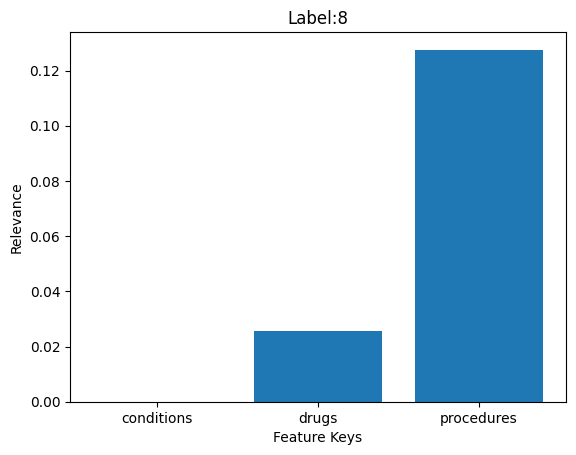

In [3]:
barPlot = []
barCategories = []
for key in sorted(rel_scores.keys()):
    barPlot.append(float(rel_scores[key].view(-1).detach().cpu()))
    barCategories.append(key)

print(barPlot)
plt.xlabel("Feature Keys")
plt.ylabel("Relevance")
plt.title("Label:" + str(sample['label']))
plt.bar(barCategories, barPlot)